# Implementation Exercise: Regularization in Practice
>Objective: Learn how to implement regularization techniques, such as L1/L2 regularization and Dropout, in neural networks to prevent overfitting.

Regularizers applies penalties on layer parameters or layer activity during optimization. These penalties are summed into the loss function that the network optimizes.

[tf.keras.regularizers.Regularizer](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer)

These layers expose 3 keyword arguments:

- kernel_regularizer: Regularizer to apply a penalty on the layer's kernel
- bias_regularizer: Regularizer to apply a penalty on the layer's bias
- activity_regularizer: Regularizer to apply a penalty on the layer's output

[tf.keras.layers.Droput](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)

The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time.

## Setup
Begin by importing the necessary libraries and preparing a dataset. For simplicity, we'll continue using a synthetic dataset for a binary classification task.

In [82]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, delimiter=";")

# Preprocess the dataset: Predicting wine quality (binary classification: good or bad)
data['quality'] = data['quality'].apply(lambda x: 1 if x >= 6 else 0)

# Splitting the data into features and target
X = data.drop('quality', axis=1)
y = data['quality'].values

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [83]:
X_train.shape

(1279, 11)

## Define the Base Neural Network Model
Create a function to build a simple neural network model without regularization. This will serve as our baseline for comparison.

In [84]:
def build_base_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(20, activation='relu', input_shape=(11,)),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


## Implement L1/L2 Regularization
Add L1 and/or L2 regularization to the model. Modify the build_base_model function to include L1/L2 regularization in the dense hidden layers. hint: check the kernel_regularizer parameter in the tf.keras.layers.Dense

Keras source code: 
[L1](https://github.com/keras-team/keras/blob/68f9af408a1734704746f7e6fa9cfede0d6879d8/keras/regularizers.py#L260)
[L2](https://github.com/keras-team/keras/blob/68f9af408a1734704746f7e6fa9cfede0d6879d8/keras/regularizers.py#L294)

In [85]:
from tensorflow.keras import regularizers

# TASK: Modify this function to include L1 or L2 regularization
def build_regularized_model(l1=0.01, l2=0.01):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(20, activation='relu', input_shape=(11,)),
        tf.keras.layers.Dense(20, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


## Implement Dropout
Incorporate Dropout into the neural network. Modify the build_base_model function to add Dropout layers after each hidden layer. hint: tf.keras.layers.Dropout

In [86]:
# TASK: Modify this function to include Dropout
def build_dropout_model(dropout_rate=0.2):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(20, activation='relu', input_shape=(11,)),
        tf.keras.layers.Dropout(rate=dropout_rate),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dropout(rate=dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

## Train and Evaluate Models
Train and evaluate the base model, the regularized model, and the dropout model. Compare their performance.

In [87]:
# Training and evaluation helper function
def train_and_evaluate(model, epochs=500):
    history = model.fit(X_train, y_train, epochs=epochs, verbose=0, validation_split=0.2)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    return history, test_loss, test_accuracy

# Base model
base_model = build_base_model()
base_history, base_loss, base_accuracy = train_and_evaluate(base_model)

# Regularized model
regularized_model = build_regularized_model(l1=0.01, l2=0.01)
reg_history, reg_loss, reg_accuracy = train_and_evaluate(regularized_model)

# Dropout model
dropout_model = build_dropout_model(dropout_rate=0.2)
drop_history, drop_loss, drop_accuracy = train_and_evaluate(dropout_model)


## Visualization and Analysis
Plot the training and validation accuracy of each model to compare their performance.

In [99]:
base_loss, reg_loss, drop_loss

(0.7152780294418335, 0.5390358567237854, 0.489147812128067)

In [100]:
base_accuracy, reg_accuracy, drop_accuracy

(0.753125011920929, 0.7406250238418579, 0.78125)

In [106]:
import plotly.graph_objects as go

# Plot training performance
def plot_metrics(history_list, model_names, subheading, title="Keras Model Comparison | "):
    fig_acc = go.Figure()
    fig_loss = go.Figure()

    for history, model_name in zip(history_list, model_names):
        fig_acc.add_trace(go.Scatter(x=history.epoch, y=history.history['accuracy'],
                                          mode='lines+markers', name=f'{model_name} Train Accuracy'))
        fig_acc.add_trace(go.Scatter(x=history.epoch, y=history.history['val_accuracy'],
                                          mode='lines+markers', name=f'{model_name} Validation Accuracy'))

        fig_loss.add_trace(go.Scatter(x=history.epoch, y=history.history['loss'],
                                      mode='lines+markers', name=f'{model_name} Train Loss'))
        fig_loss.add_trace(go.Scatter(x=history.epoch, y=history.history['val_loss'],
                                      mode='lines+markers', name=f'{model_name} Validation Loss'))

    fig_acc.update_layout(title=f'{title} Accuracy ({subheading})',
                               xaxis_title='Epoch',
                               yaxis_title='Accuracy',
                               legend=dict(x=1.02, y=1),
                               margin=dict(l=0, r=0, t=40, b=0),
                               height=700)
    
    fig_loss.update_layout(title=f'{title} Loss ({subheading})',
                           xaxis_title='Epoch',
                           yaxis_title='Loss',
                           legend=dict(x=1.02, y=1),
                           margin=dict(l=0, r=0, t=40, b=0),
                           height=700)

    fig_acc.show()
    fig_loss.show()

history_list = [base_history, reg_history, drop_history]
model_names = ['Base', 'Regularized', 'Dropout']

plot_metrics(history_list, model_names, "Reg: l1=0.01, l2=0.01, Dropout=0.2")


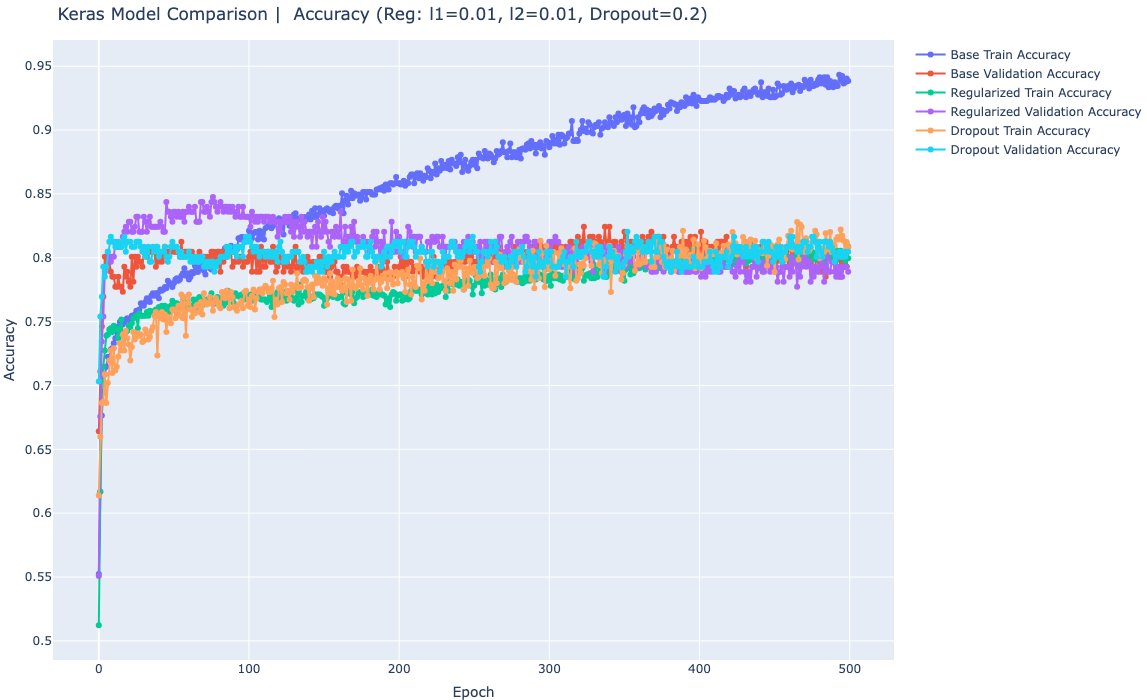
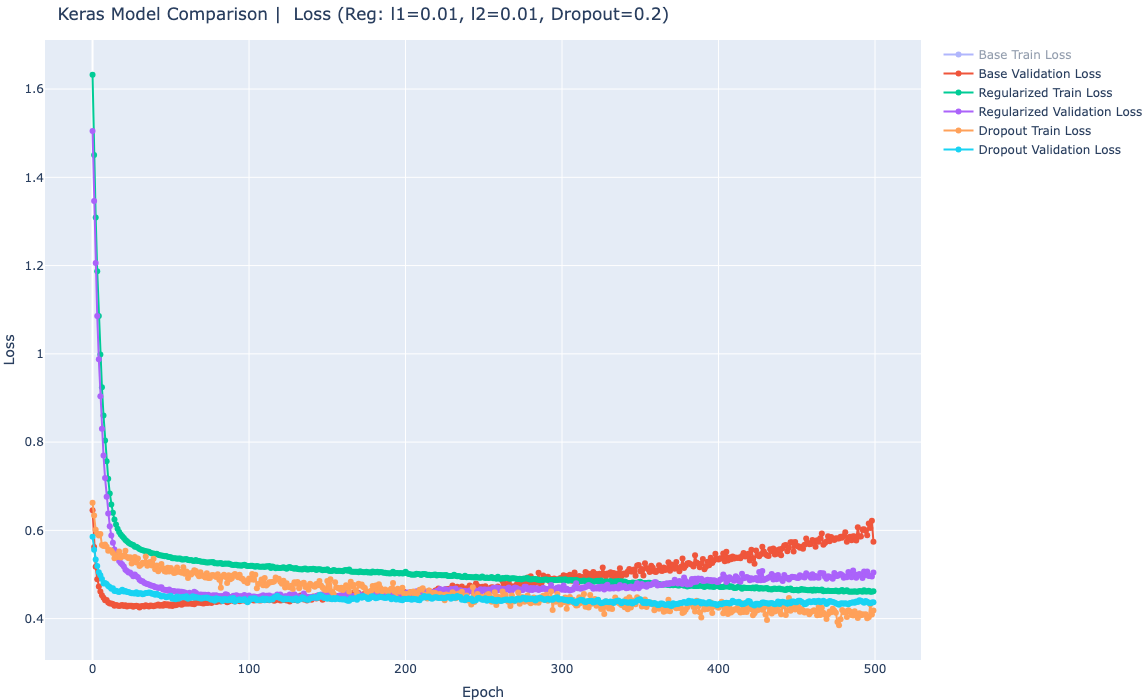

Well, without regularization, the model overfits. It scores way too high on train accuracy.

## Tasks and Questions
1. Implement L1/L2 regularization and Dropout in the provided model structures.
2. Implement the visualizations.
3. Observe the effect of each technique on model performance.
4. Discuss which regularization technique seemed most effective and why.


In [109]:
l1_l2_low=build_regularized_model(l1=0.001,l2=0.001) # Test 0.001 instead of 0.01

l1_l2_low_history, l1_l2_low_loss, l1_l2_low_acc = train_and_evaluate(l1_l2_low)

In [110]:
l1_l2_low_loss, l1_l2_low_acc

(0.6721113324165344, 0.746874988079071)

In [111]:
plot_metrics([base_history, l1_l2_low_history], ['Base', "L1&L2"], "Regularized: L1=0.001, L2=0.001")

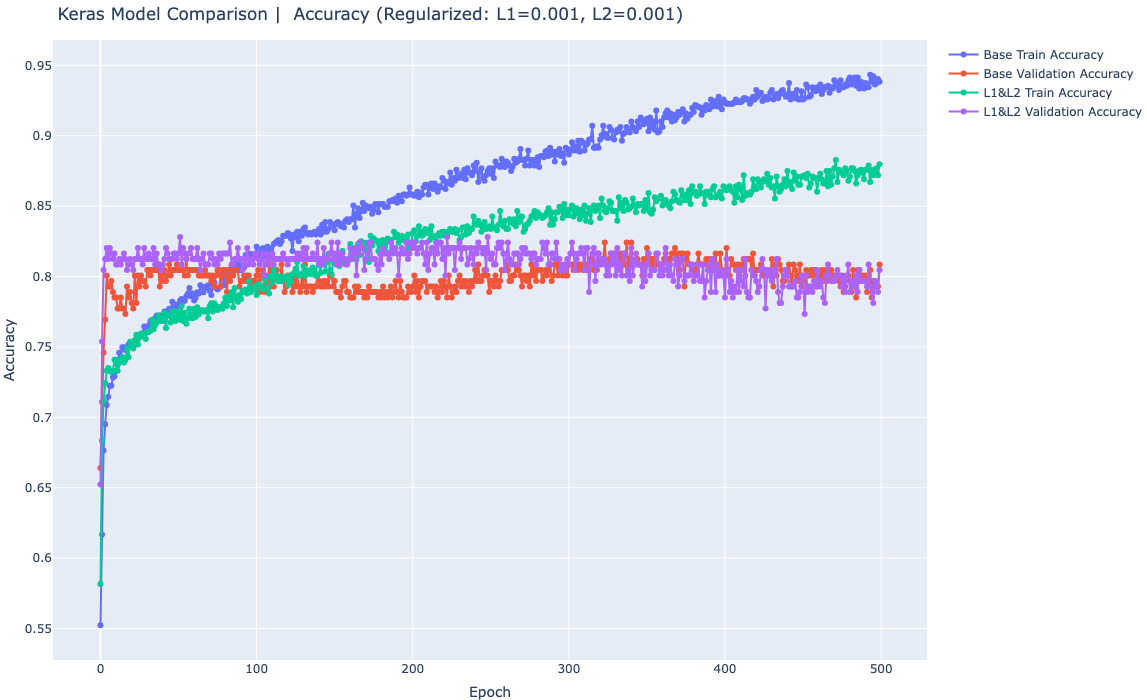
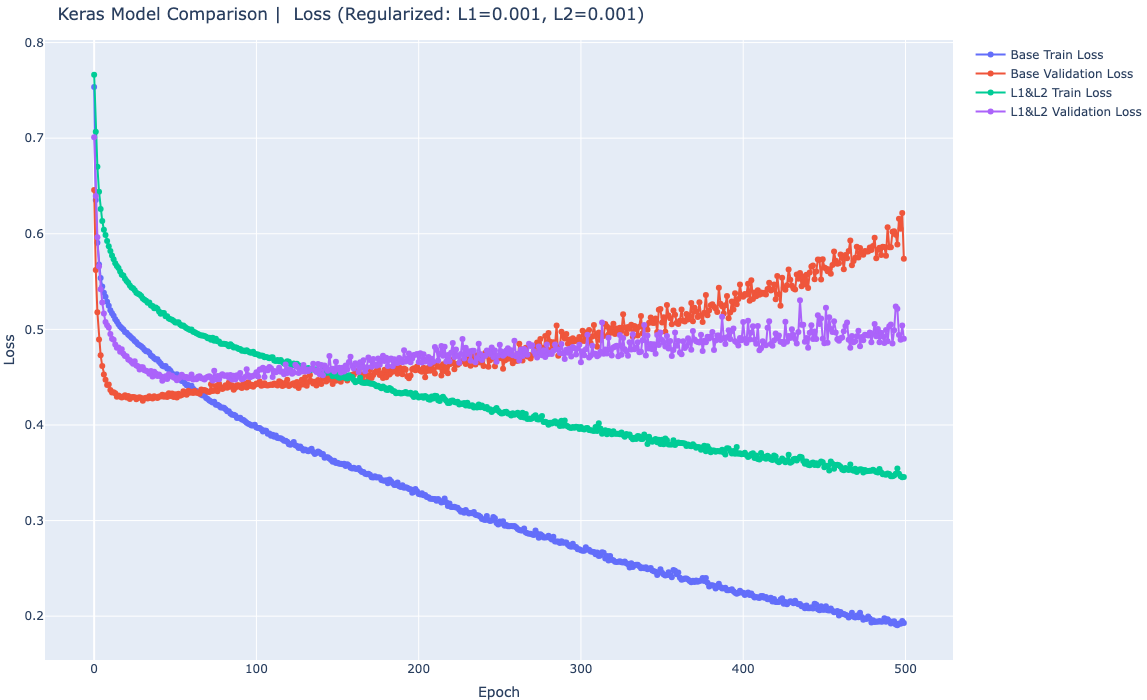

Well, thats an improvement.

In [115]:
l1_only=build_regularized_model(l1=0.001,l2=None)

l1_only_history, l1_only_loss, l1_only_acc = train_and_evaluate(l1_only)

In [113]:
l1_only_loss, l1_only_acc

(0.604773998260498, 0.768750011920929)

Accuracy on test is in fact better.

In [116]:
plot_metrics([base_history, l1_only_history], ['Base', 'l1_only'], "L1=0.001, L2=None", "L1 Only")

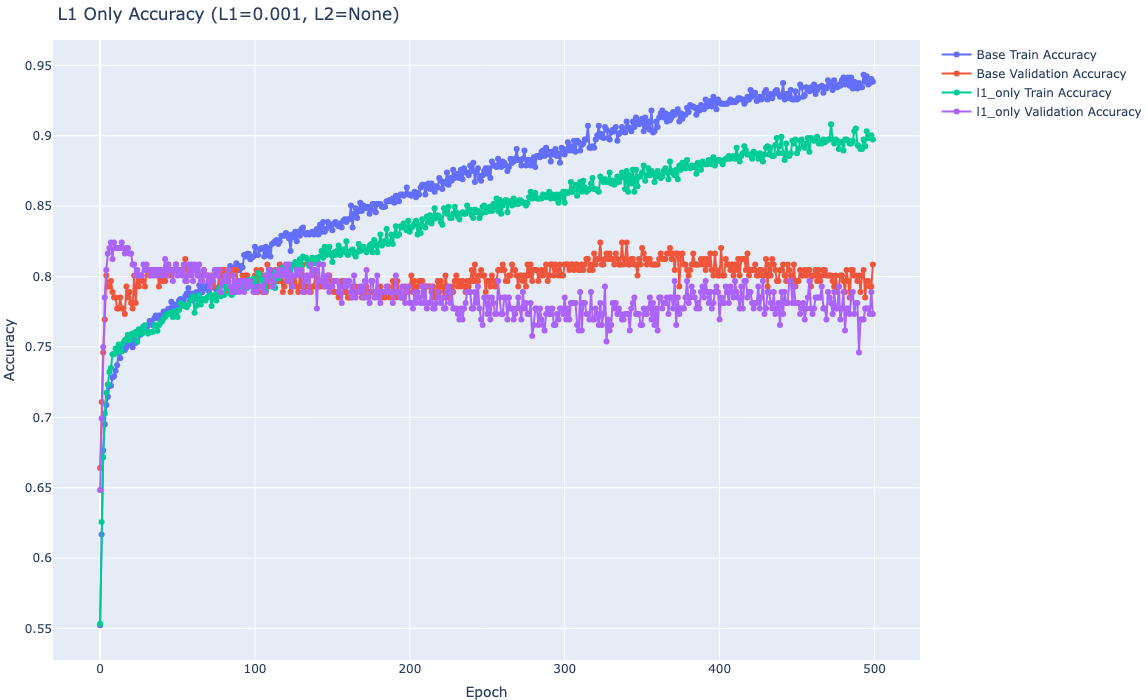
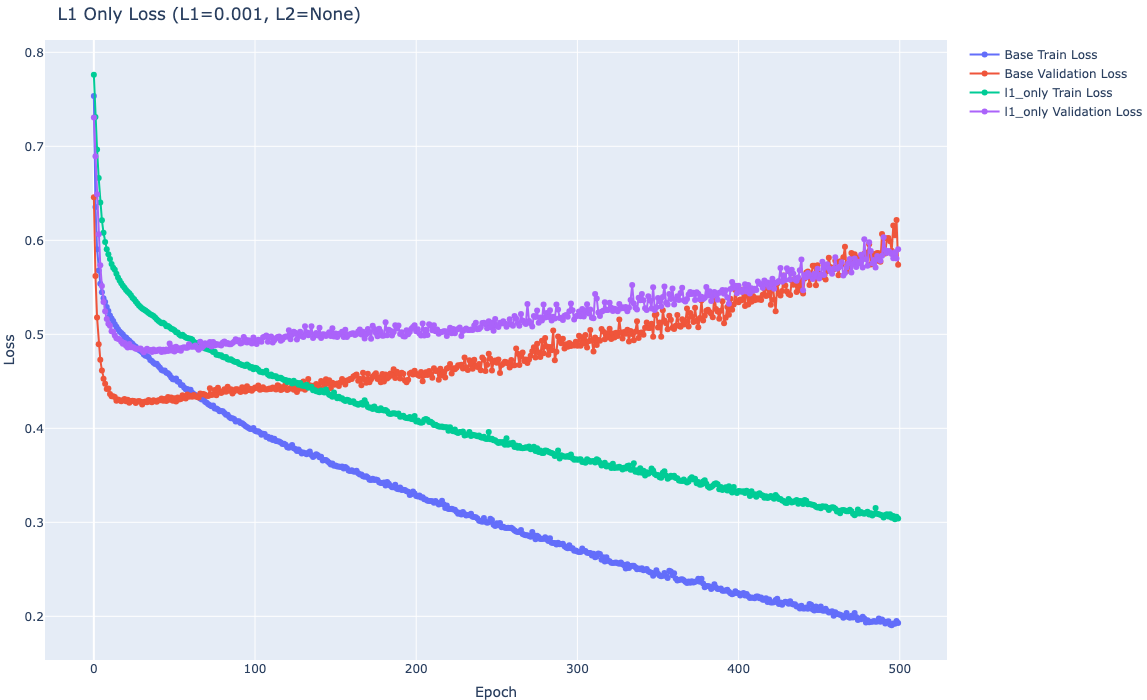

I guess that's ok. Still some overfit. Let's try L2 only.

In [121]:
l2_only=build_regularized_model(l1=None,l2=0.001)

l2_only, l2_only_loss, l2_only_acc = train_and_evaluate(l2_only)

plot_metrics([l2_only], ['l2_only'], "l2=0.001", "L2 Only")

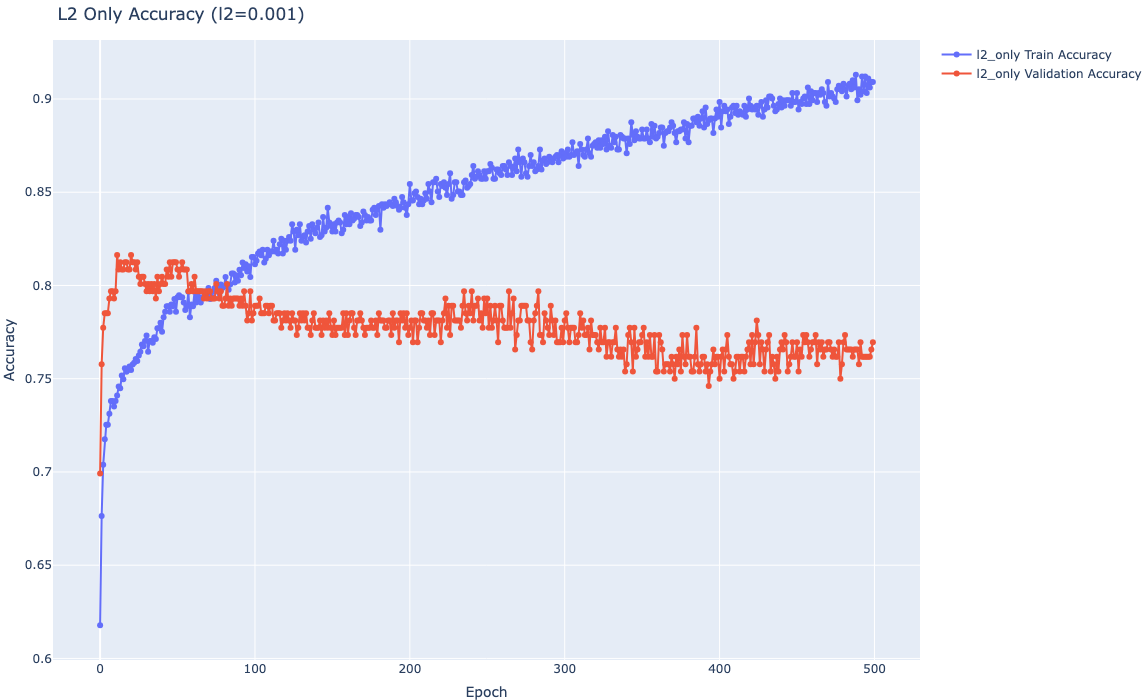
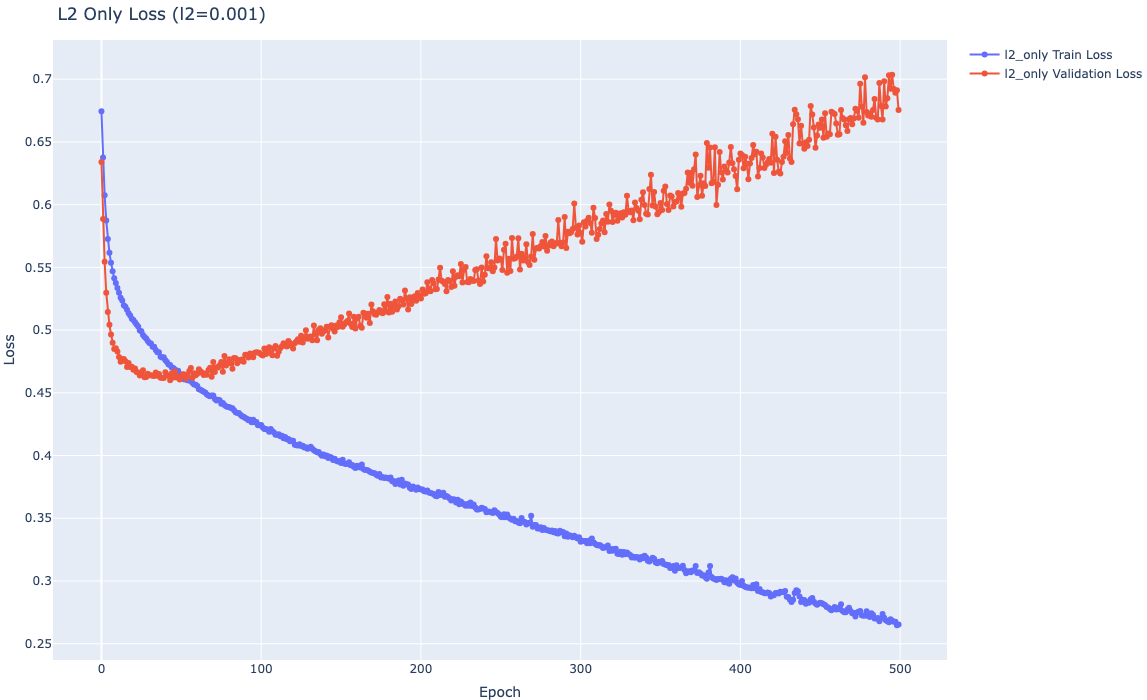

91 acc on train. That's also an overfit. (And what's going on with that validation loss???)

In [122]:
l2_only_acc

0.768750011920929

In [119]:
l1_001_l2_0001 = build_regularized_model(l1=0.01,l2=0.001)

l1_001_l2_0001, l1_001_l2_0001_loss, l1_001_l2_0001_acc = train_and_evaluate(l1_001_l2_0001)

plot_metrics([l1_001_l2_0001], ['l1_001_l2_0001'], "l1=0.01,l2=0.001")

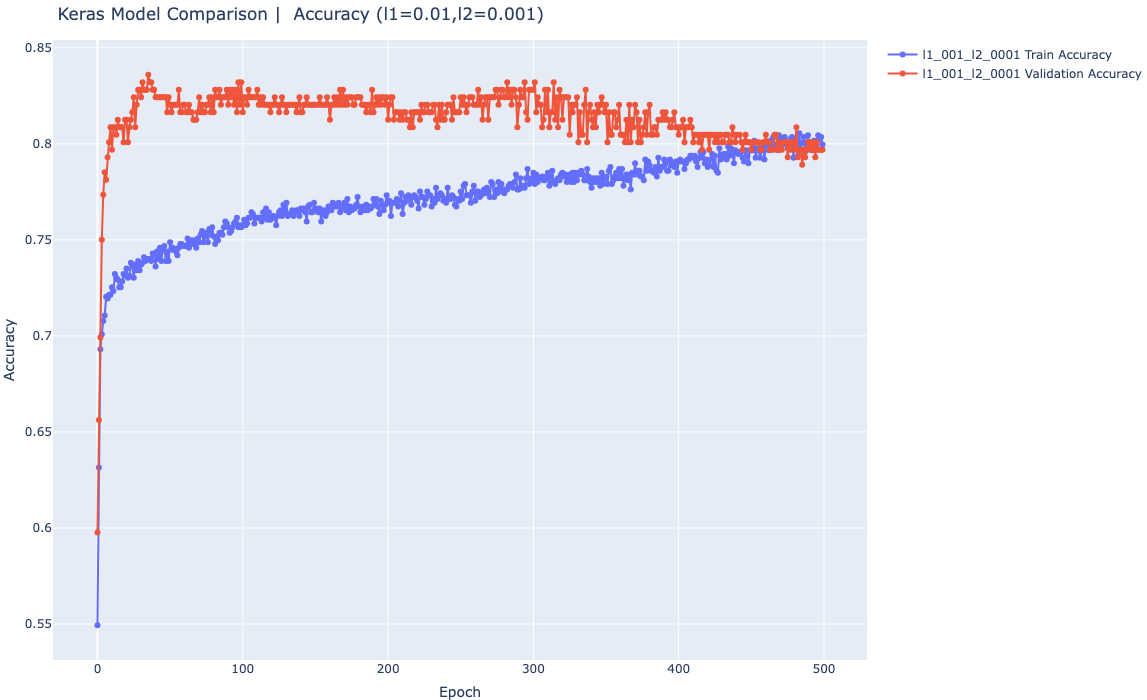
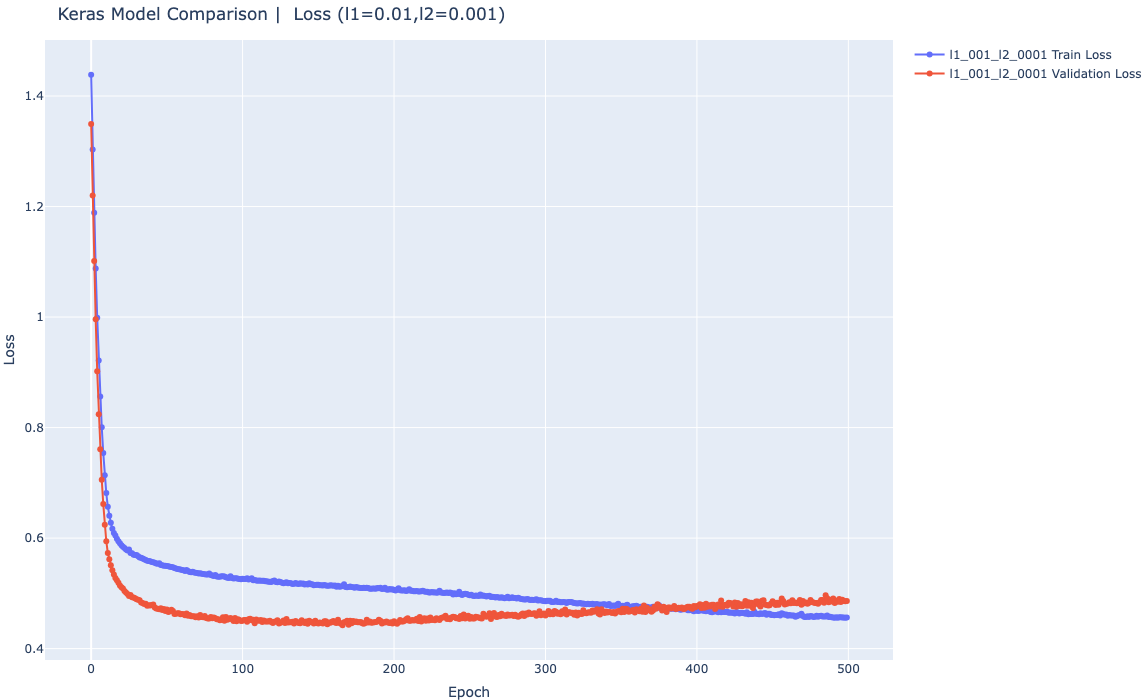

That's very interesting. It converged both acc and loss early. This is stable.

In [120]:
l1_001_l2_0001_loss, l1_001_l2_0001_acc

(0.510881781578064, 0.75)

Accuracy on test still very similar, but the model isn't overfit.


Let's test some dropout factors instead.

In [93]:
dp005 = build_dropout_model(0.005)
dp01 = build_dropout_model(0.1)
dp05 = build_dropout_model(0.5)
dp09 = build_dropout_model(0.9)

In [94]:
_, dp005_loss, dp005_acc = train_and_evaluate(dp005)
_, dp01_loss, dp01_acc = train_and_evaluate(dp01)
_, dp05_loss, dp05_acc = train_and_evaluate(dp05)
_, dp09_loss, dp09_acc = train_and_evaluate(dp09)

In [95]:
dp005_acc,dp01_acc,dp05_acc,dp09_acc

(0.7406250238418579, 0.75, 0.731249988079071, 0.7437499761581421)

Default dropout (0.2 ) still outperformed these factors.


## Conclusion
Reflect on the importance of regularization techniques in training neural networks and their impact on model performance and generalization

It's all bout that hyperparamtuning. Gridsearch should probably be used initially to give us a hint about which direction to continue finetuning.

Although the training looks better for base model (no regularization), the models might perform better with regularization.

In [118]:
base_accuracy, reg_accuracy, drop_accuracy, l1_only_acc

(0.753125011920929, 0.7406250238418579, 0.78125, 0.753125011920929)

I've learned that there are improvements that can be made with regularization, but I think the input data and feature engineering is more important.